# 🔪 JAX - The Sharp Bits 🔪

*levskaya@ mattjj@*

When walking about the countryside of [Italy](https://iaml.it/blog/jax-intro), the people will not hesitate to tell you that __JAX__ has _"una anima di pura programmazione funzionale"_.

__JAX__ is a language for __expressing__ and __composing__ __transformations__ of numerical programs. __JAX__ is also able to __compile__ numerical programs for CPU or accelerators (GPU/TPU). 
JAX works great for many numerical and scientific programs, but __only if they are written with certain constraints__ that we describe below.

In [0]:
import numpy as onp
from jax import grad, jit
from jax import lax
from jax import random
import jax
import jax.numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False

## 🔪 Pure functions

JAX transformation and compilation are designed to work only on Python functions that are functionally pure: all the input data is passed through the function parameters, all the results are output through the function results. A pure function will always return the same result if invoked with the same inputs. 

Here are some examples of functions that are not functially pure for which JAX behaves differently than the Python interpreter. Note that these behaviors are not guaranteed by the JAX system; the proper way to use JAX is to use it only on functionally pure Python functions.


In [121]:
def impure_print_side_effect(x):
  print("Executing function")  # This is a side-effect 
  return x

# The side-effects appear during the first run  
print ("First call: ", jit(impure_print_side_effect)(4.))

# Subsequent runs with parameters of same type and shape may not show the side-effect
# This is because JAX now invokes a cached compilation of the function
print ("Second call: ", jit(impure_print_side_effect)(5.))

# JAX re-runs the Python function when the type or shape of the argument changes
print ("Third call, different type: ", jit(impure_print_side_effect)(np.array([5.])))

Executing function
First call:  4.0
Second call:  5.0
Executing function
Third call, different type:  [5.]


In [122]:
g = 0.
def impure_uses_globals(x):
  return x + g

# JAX captures the value of the global during the first run
print ("First call: ", jit(impure_uses_globals)(4.))
g = 10.  # Update the global

# Subsequent runs may silently use the cached value of the globals
print ("Second call: ", jit(impure_uses_globals)(5.))

# JAX re-runs the Python function when the type or shape of the argument changes
# This will end up reading the latest value of the global
print ("Third call, different type: ", jit(impure_uses_globals)(np.array([4.])))

First call:  4.0
Second call:  5.0
Third call, different type:  [14.]


In [123]:
g = 0.
def impure_saves_global(x):
  global g
  g = x
  return x

# JAX runs once the transformed function with special Traced values for arguments
print ("First call: ", jit(impure_saves_global)(4.))
print ("Saved global: ", g)  # Saved global has an internal JAX value

First call:  4.0
Saved global:  Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=-1/1)>


A Python function can be functionally pure even if it actually uses stateful objects internally, as long as it does not read or write external state:

In [ ]:

def pure_uses_internal_state(x):
  state = dict(even=0, odd=0)
  for i in range(10):
    state['even' if i % 2 == 0 else 'odd'] += x
  return state['even'] + state['odd']

print(jit(pure_uses_internal_state)(5.))

It is not recommended to use iterators in any JAX function you want to `jit` or in any control-flow primitive. The reason is that an iterator is a python object which introduces state to retrieve the next element. Therefore, it is incompatible with JAX functional programming model. In the code below, there are some examples of incorrect attempts to use iterators with JAX. Most of them return an error, but some give unexpected results.

In [1]:
import jax.numpy as jnp
import jax.lax as lax
from jax import make_jaxpr

# lax.fori_loop
array = jnp.arange(10)
print(lax.fori_loop(0, 10, lambda i,x: x+array[i], 0)) # expected result 45
iterator = iter(range(10))
print(lax.fori_loop(0, 10, lambda i,x: x+next(iterator), 0)) # unexpected result 0

# lax.scan
def func11(arr, extra):
    ones = jnp.ones(arr.shape)  
    def body(carry, aelems):
        ae1, ae2 = aelems
        return (carry + ae1 * ae2 + extra, carry)
    return lax.scan(body, 0., (arr, ones))    
make_jaxpr(func11)(jnp.arange(16), 5.)
# make_jaxpr(func11)(iter(range(16)), 5.) # throws error

# lax.cond
array_operand = jnp.array([0.])
lax.cond(True, array_operand, lambda x: x+1, array_operand, lambda x: x-1)
iter_operand = iter(range(10))
# lax.cond(True, iter_operand, lambda x: next(x)+1, iter_operand, lambda x: next(x)-1) # throws error

45
0


/Users/igor/projects/jax/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


## 🔪 In-Place Updates

In Numpy you're used to doing this:

In [125]:
numpy_array = onp.zeros((3,3), dtype=np.float32)
print("original array:")
print(numpy_array)

# In place, mutating update
numpy_array[1, :] = 1.0
print("updated array:")
print(numpy_array)

original array:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
updated array:
[[0. 0. 0.]
 [1. 1. 1.]
 [0. 0. 0.]]


If we try to update a JAX device array in-place, however, we get an __error__!  (☉_☉)

In [126]:
jax_array = np.zeros((3,3), dtype=np.float32)

# In place update of JAX's array will yield an error!
try:
  jax_array[1, :] = 1.0
except Exception as e:
  print("Exception {}".format(e))

Exception '<class 'jax.interpreters.xla.DeviceArray'>' object does not support item assignment. JAX arrays are immutable; perhaps you want jax.ops.index_update or jax.ops.index_add instead?


__What gives?!__  

Allowing mutation of variables in-place makes program analysis and transformation very difficult. JAX requires a pure functional expression of a numerical program.  

Instead, JAX offers the _functional_ update functions: [__index_update__](https://jax.readthedocs.io/en/latest/_autosummary/jax.ops.index_update.html#jax.ops.index_update), [__index_add__](https://jax.readthedocs.io/en/latest/_autosummary/jax.ops.index_add.html#jax.ops.index_add), [__index_min__](https://jax.readthedocs.io/en/latest/_autosummary/jax.ops.index_min.html#jax.ops.index_min), [__index_max__](https://jax.readthedocs.io/en/latest/_autosummary/jax.ops.index_max.html#jax.ops.index_max), and the [__index__](https://jax.readthedocs.io/en/latest/_autosummary/jax.ops.index.html#jax.ops.index) helper.

️⚠️ inside `jit`'d code and `lax.while_loop` or `lax.fori_loop` the __size__ of slices can't be functions of argument _values_ but only functions of argument _shapes_ -- the slice start indices have no such restriction.  See the below __Control Flow__ Section for more information on this limitation.

In [0]:
from jax.ops import index, index_add, index_update

### index_update

If the __input values__ of __index_update__ aren't reused, __jit__-compiled code will perform these operations _in-place_.

In [128]:
jax_array = np.zeros((3, 3))
print("original array:")
print(jax_array)

new_jax_array = index_update(jax_array, index[1, :], 1.)

print("old array unchanged:")
print(jax_array)

print("new array:")
print(new_jax_array)

original array:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
old array unchanged:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
new array:
[[0. 0. 0.]
 [1. 1. 1.]
 [0. 0. 0.]]


### index_add

If the __input values__ of __index_update__ aren't reused, __jit__-compiled code will perform these operations _in-place_.

In [129]:
print("original array:")
jax_array = np.ones((5, 6))
print(jax_array)

new_jax_array = index_add(jax_array, index[::2, 3:], 7.)
print("new array post-addition:")
print(new_jax_array)

original array:
[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
new array post-addition:
[[1. 1. 1. 8. 8. 8.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 8. 8. 8.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 8. 8. 8.]]


## 🔪 Out-of-Bounds Indexing

In Numpy, you are used to errors being thrown when you index an array outside of its bounds, like this:

In [130]:
try:
  onp.arange(10)[11]
except Exception as e:
  print("Exception {}".format(e))

Exception index 11 is out of bounds for axis 0 with size 10


However, raising an error on other accelerators can be more difficult. Therefore, JAX does not raise an error and instead returns the last value in the array. 

In [131]:
np.arange(10)[11]

DeviceArray(9, dtype=int32)

Note that due to this behavior np.nanargmin and np.nanargmax return -1 for slices consisting of NaNs whereas Numpy would throw an error.

## 🔪 Random Numbers

> _If all scientific papers whose results are in doubt because of bad 
> `rand()`s were to disappear from library shelves, there would be a 
> gap on each shelf about as big as your fist._ - Numerical Recipes

### RNGs and State
You're used to _stateful_ pseudorandom number generators (PRNGs) from numpy and other libraries, which helpfully hide a lot of details under the hood to give you a ready fountain of pseudorandomness:

In [132]:
print(onp.random.random())
print(onp.random.random())
print(onp.random.random())

0.08960303423860538
0.6720478073539145
0.24536720985284477


Underneath the hood, numpy uses the [Mersenne Twister](https://en.wikipedia.org/wiki/Mersenne_Twister) PRNG to power its pseudorandom functions.  The PRNG has a period of $2^{19937}-1$ and at any point can be described by __624 32bit unsigned ints__ and a __position__ indicating how much of this  "entropy" has been used up.

In [0]:
onp.random.seed(0)
rng_state = onp.random.get_state()
#print(rng_state)
# --> ('MT19937', array([0, 1, 1812433255, 1900727105, 1208447044,
#       2481403966, 4042607538,  337614300, ... 614 more numbers..., 
#       3048484911, 1796872496], dtype=uint32), 624, 0, 0.0)

This pseudorandom state vector is automagically updated behind the scenes every time a random number is needed, "consuming" 2 of the uint32s in the Mersenne twister state vector:

In [0]:
_ = onp.random.uniform()
rng_state = onp.random.get_state()
#print(rng_state) 
# --> ('MT19937', array([2443250962, 1093594115, 1878467924,
#       ..., 2648828502, 1678096082], dtype=uint32), 2, 0, 0.0)

# Let's exhaust the entropy in this PRNG statevector
for i in range(311):
  _ = onp.random.uniform()
rng_state = onp.random.get_state()
#print(rng_state) 
# --> ('MT19937', array([2443250962, 1093594115, 1878467924,
#       ..., 2648828502, 1678096082], dtype=uint32), 624, 0, 0.0)

# Next call iterates the RNG state for a new batch of fake "entropy".
_ = onp.random.uniform()
rng_state = onp.random.get_state()
# print(rng_state) 
# --> ('MT19937', array([1499117434, 2949980591, 2242547484, 
#      4162027047, 3277342478], dtype=uint32), 2, 0, 0.0)

The problem with magic PRNG state is that it's hard to reason about how it's being used and updated across different threads, processes, and devices, and it's _very easy_ to screw up when the details of entropy production and consumption are hidden from the end user.

The Mersenne Twister PRNG is also known to have a [number](https://cs.stackexchange.com/a/53475) of problems, it has a large 2.5Kb state size, which leads to problematic [initialization issues](https://dl.acm.org/citation.cfm?id=1276928).  It [fails](http://www.pcg-random.org/pdf/toms-oneill-pcg-family-v1.02.pdf) modern BigCrush tests, and is generally slow. 

### JAX PRNG


JAX instead implements an _explicit_ PRNG where entropy production and consumption are handled by explicitly passing and iterating PRNG state.  JAX uses a modern [Three-fry counter-based PRNG](https://github.com/google/jax/blob/master/design_notes/prng.md) that's __splittable__.  That is, its design allows us to __fork__ the PRNG state into new PRNGs for use with parallel stochastic generation.

The random state is described by two unsigned-int32s that we call a __key__:

In [135]:
from jax import random
key = random.PRNGKey(0)
key

DeviceArray([0, 0], dtype=uint32)

JAX's random functions produce pseudorandom numbers from the PRNG state, but __do not__ change the state!  

Reusing the same state will cause __sadness__ and __monotony__, depriving the enduser of __lifegiving chaos__:

In [136]:
print(random.normal(key, shape=(1,)))
print(key)
# No no no!
print(random.normal(key, shape=(1,)))
print(key)

[-0.20584226]
[0 0]
[-0.20584226]
[0 0]


Instead, we __split__ the PRNG to get usable __subkeys__ every time we need a new pseudorandom number:

In [137]:
print("old key", key)
key, subkey = random.split(key)
normal_pseudorandom = random.normal(subkey, shape=(1,))
print("    \---SPLIT --> new key   ", key)
print("             \--> new subkey", subkey, "--> normal", normal_pseudorandom)

old key [0 0]
    \---SPLIT --> new key    [4146024105  967050713]
             \--> new subkey [2718843009 1272950319] --> normal [-1.2515389]


We propagate the __key__ and make new __subkeys__ whenever we need a new random number:

In [138]:
print("old key", key)
key, subkey = random.split(key)
normal_pseudorandom = random.normal(subkey, shape=(1,))
print("    \---SPLIT --> new key   ", key)
print("             \--> new subkey", subkey, "--> normal", normal_pseudorandom)

old key [4146024105  967050713]
    \---SPLIT --> new key    [2384771982 3928867769]
             \--> new subkey [1278412471 2182328957] --> normal [-0.58665055]


We can generate more than one __subkey__ at a time:

In [139]:
key, *subkeys = random.split(key, 4)
for subkey in subkeys:
  print(random.normal(subkey, shape=(1,)))

[-0.37533438]
[0.98645043]
[0.14553197]


## 🔪 Control Flow

### ✔ python control_flow + autodiff ✔

If you just want to apply `grad` to your python functions, you can use regular python control-flow constructs with no problems, as if you were using [Autograd](https://github.com/hips/autograd) (or Pytorch or TF Eager).

In [140]:
def f(x):
  if x < 3:
    return 3. * x ** 2
  else:
    return -4 * x

print(grad(f)(2.))  # ok!
print(grad(f)(4.))  # ok!

12.0
-4.0


### python control flow + JIT

Using control flow with `jit` is more complicated, and by default it has more constraints.

This works:

In [141]:
@jit
def f(x):
  for i in range(3):
    x = 2 * x
  return x

print(f(3))

24


So does this:

In [142]:
@jit
def g(x):
  y = 0.
  for i in range(x.shape[0]):
    y = y + x[i]
  return y

print(g(np.array([1., 2., 3.])))

6.0


But this doesn't, at least by default:

In [143]:
@jit
def f(x):
  if x < 3:
    return 3. * x ** 2
  else:
    return -4 * x

# This will fail!
try:
  f(2)
except Exception as e:
  print("Exception {}".format(e))

Exception Abstract value passed to `bool`, which requires a concrete value. The function to be transformed can't be traced at the required level of abstraction. If using `jit`, try using `static_argnums` or applying `jit` to smaller subfunctions instead.


__What gives!?__

When we `jit`-compile a function, we usually want to compile a version of the function that works for many different argument values, so that we can cache and reuse the compiled code. That way we don't have to re-compile on each function evaluation.

For example, if we evaluate an `@jit` function on the array `np.array([1., 2., 3.], np.float32)`, we might want to compile code that we can reuse to evaluate the function on `np.array([4., 5., 6.], np.float32)` to save on compile time.

To get a view of your Python code that is valid for many different argument values, JAX traces it on _abstract values_ that represent sets of possible inputs. There are [multiple different levels of abstraction](https://github.com/google/jax/blob/master/jax/abstract_arrays.py), and different transformations use different abstraction levels.

By default, `jit` traces your code on the `ShapedArray` abstraction level, where each abstract value represents the set of all array values with a fixed shape and dtype. For example, if we trace using the abstract value `ShapedArray((3,), np.float32)`, we get a view of the function that can be reused for any concrete value in the corresponding set of arrays. That means we can save on compile time.

But there's a tradeoff here: if we trace a Python function on a `ShapedArray((), np.float32)` that isn't committed to a specific concrete value, when we hit a line like `if x < 3`, the expression `x < 3` evaluates to an abstract `ShapedArray((), np.bool_)` that represents the set `{True, False}`. When Python attempts to coerce that to a concrete `True` or `False`, we get an error: we don't know which branch to take, and can't continue tracing! The tradeoff is that with higher levels of abstraction we gain a more general view of the Python code (and thus save on re-compilations), but we require more constraints on the Python code to complete the trace.

The good news is that you can control this tradeoff yourself. By having `jit` trace on more refined abstract values, you can relax the traceability constraints. For example, using the `static_argnums` argument to `jit`, we can specify to trace on concrete values of some arguments. Here's that example function again:

In [144]:
def f(x):
  if x < 3:
    return 3. * x ** 2
  else:
    return -4 * x

f = jit(f, static_argnums=(0,))

print(f(2.))

12.0


Here's another example, this time involving a loop:

In [145]:
def f(x, n):
  y = 0.
  for i in range(n):
    y = y + x[i]
  return y

f = jit(f, static_argnums=(1,))

f(np.array([2., 3., 4.]), 2)

DeviceArray(5., dtype=float32)

In effect, the loop gets statically unrolled.  JAX can also trace at _higher_ levels of abstraction, like `Unshaped`, but that's not currently the default for any transformation

️⚠️ **functions with argument-__value__ dependent shapes**

These control-flow issues also come up in a more subtle way: numerical functions we want to __jit__ can't specialize the shapes of internal arrays on argument _values_ (specializing on argument __shapes__ is ok).  As a trivial example, let's make a function whose output happens to depend on the input variable `length`.

In [146]:
def example_fun(length, val):
  return np.ones((length,)) * val
# un-jit'd works fine
print(example_fun(5, 4))

bad_example_jit = jit(example_fun)
# this will fail:
try:
  print(bad_example_jit(10, 4))
except Exception as e:
  print("Exception {}".format(e))
# static_argnums tells JAX to recompile on changes at these argument positions:
good_example_jit = jit(example_fun, static_argnums=(0,))
# first compile
print(good_example_jit(10, 4))
# recompiles
print(good_example_jit(5, 4))

[4. 4. 4. 4. 4.]
Exception Shapes must be 1D sequences of concrete values of integer type, got (Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>,).
If using `jit`, try using `static_argnums` or applying `jit` to smaller subfunctions.
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
[4. 4. 4. 4. 4.]


`static_argnums` can be handy if `length` in our example rarely changes, but it would be disastrous if it changed a lot!  

Lastly, if your function has global side-effects, JAX's tracer can cause weird things to happen. A common gotcha is trying to print arrays inside __jit__'d functions: 

In [147]:
@jit
def f(x):
  print(x)
  y = 2 * x
  print(y)
  return y
f(2)

Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>
Traced<ShapedArray(int32[]):JaxprTrace(level=-1/1)>


DeviceArray(4, dtype=int32)

### Structured control flow primitives

There are more options for control flow in JAX. Say you want to avoid re-compilations but still want to use control flow that's traceable, and that avoids un-rolling large loops. Then you can use these 4 structured control flow primitives:

 - `lax.cond`  _differentiable_
 - `lax.while_loop` __fwd-mode-differentiable__
 - `lax.fori_loop` __fwd-mode-differentiable__
 - `lax.scan` _differentiable_



#### cond
python equivalent:

```
def cond(pred, true_operand, true_fun, false_operand, false_fun):
  if pred:
    return true_fun(true_operand)
  else:
    return false_fun(false_operand)
```

In [148]:
from jax import lax

operand = np.array([0.])
lax.cond(True, operand, lambda x: x+1, operand, lambda x: x-1)
# --> array([1.], dtype=float32)
lax.cond(False, operand, lambda x: x+1, operand, lambda x: x-1)
# --> array([-1.], dtype=float32)

DeviceArray([-1.], dtype=float32)

#### while_loop

python equivalent:
```
def while_loop(cond_fun, body_fun, init_val):
  val = init_val
  while cond_fun(val):
    val = body_fun(val)
  return val
```

In [149]:
init_val = 0
cond_fun = lambda x: x<10
body_fun = lambda x: x+1
lax.while_loop(cond_fun, body_fun, init_val)
# --> array(10, dtype=int32)

DeviceArray(10, dtype=int32)

#### fori_loop
python equivalent:
```
def fori_loop(start, stop, body_fun, init_val):
  val = init_val
  for i in range(start, stop):
    val = body_fun(i, val)
  return val
```

In [150]:
init_val = 0
start = 0
stop = 10
body_fun = lambda i,x: x+i
lax.fori_loop(start, stop, body_fun, init_val)
# --> array(45, dtype=int32)

DeviceArray(45, dtype=int32)

#### Summary

$$
\begin{array} {r|rr} 
\hline \
\textrm{construct} 
& \textrm{jit} 
& \textrm{grad} \\
\hline \
\textrm{if} & ❌ & ✔ \\
\textrm{for} & ✔* & ✔\\
\textrm{while} & ✔* & ✔\\
\textrm{lax.cond} & ✔ & ✔\\
\textrm{lax.while_loop} & ✔ & \textrm{fwd}\\
\textrm{lax.fori_loop} & ✔ & \textrm{fwd}\\
\textrm{lax.scan} & ✔ & ✔\\
\hline
\end{array}
$$
<center>$\ast$ = argument-__value__-independent loop condition - unrolls the loop </center>

## 🔪 Convolutions

JAX and XLA offer the very general N-dimensional __conv_general_dilated__ function, but it's not very obvious how to use it.  We'll give some examples of the common use-cases.

For the most common kinds of convolutions, see also the convenience functions lax.conv and lax.conv_general_padding, as well as jax.numpy.convolve and jax.scipy.signal.convolve/jax.scipy.signal.convolve2d for an interface similar to that of the numpy and scipy packages.

A survey of the family of convolutional operators, [a guide to convolutional arithmetic](https://arxiv.org/abs/1603.07285) is highly recommended reading!

Let's define a simple diagonal edge kernel:

Edge Conv kernel:


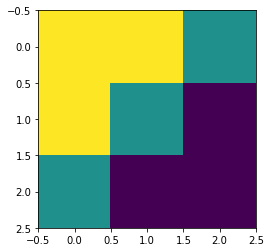

In [151]:
# 2D kernel - HWIO layout
kernel = onp.zeros((3, 3, 3, 3), dtype=np.float32)
kernel += onp.array([[1, 1, 0],
                [1, 0,-1],
                [0,-1,-1]])[:, :, onp.newaxis, onp.newaxis]

print("Edge Conv kernel:")
plt.imshow(kernel[:, :, 0, 0]);

And we'll make a simple synthetic image:

Original Image:


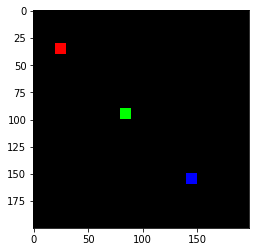

In [152]:
# NHWC layout
img = onp.zeros((1, 200, 198, 3), dtype=np.float32)
for k in range(3):
    x = 30 + 60*k
    y = 20 + 60*k
    img[0, x:x+10, y:y+10, k] = 1.0

print("Original Image:")
plt.imshow(img[0]);

### lax.conv and lax.conv_with_general_padding

These are the simple convenience functions for convolutions

️⚠️ The convenience `lax.conv`, `lax.conv_with_general_padding` helper function assume __NCHW__ images and __OIHW__ kernels.

out shape:  (1, 3, 200, 198)
First output channel:


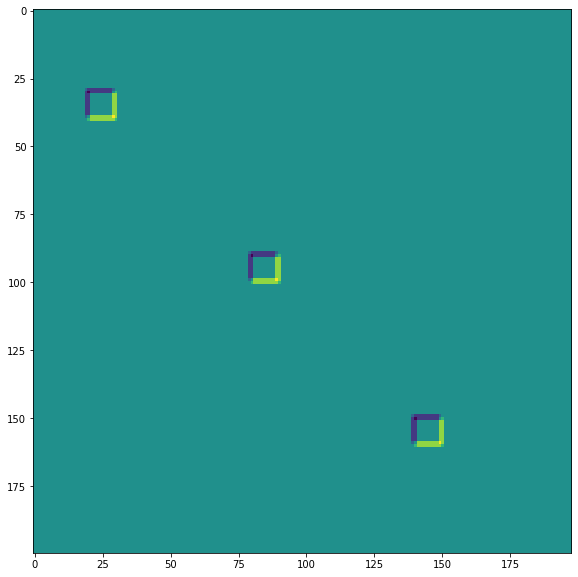

In [153]:
out = lax.conv(np.transpose(img,[0,3,1,2]),    # lhs = NCHW image tensor
               np.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
               (1, 1),  # window strides
               'SAME') # padding mode
print("out shape: ", out.shape)
print("First output channel:")
plt.figure(figsize=(10,10))
plt.imshow(onp.array(out)[0,0,:,:]);

out shape:  (1, 3, 202, 200)
First output channel:


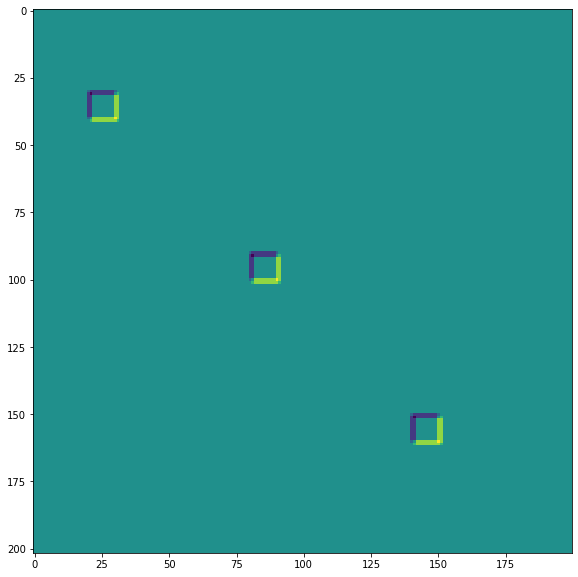

In [154]:
out = lax.conv_with_general_padding(
  np.transpose(img,[0,3,1,2]),    # lhs = NCHW image tensor
  np.transpose(kernel,[2,3,0,1]), # rhs = IOHW conv kernel tensor
  (1, 1),  # window strides
  ((2,2),(2,2)), # general padding 2x2
  (1,1),  # lhs/image dilation
  (1,1))  # rhs/kernel dilation
print("out shape: ", out.shape)
print("First output channel:")
plt.figure(figsize=(10,10))
plt.imshow(onp.array(out)[0,0,:,:]);

### Dimension Numbers define dimensional layout for conv_general_dilated

The important argument is the 3-tuple of axis layout arguments:
(Input Layout, Kernel Layout, Output Layout)
 - __N__ - batch dimension
 - __H__ - spatial height
 - __W__ - spatial height
 - __C__ - channel dimension
 - __I__ - kernel _input_ channel dimension
 - __O__ - kernel _output_ channel dimension

⚠️ To demonstrate the flexibility of dimension numbers we choose a __NHWC__ image and __HWIO__ kernel convention for `lax.conv_general_dilated` below.

In [155]:
dn = lax.conv_dimension_numbers(img.shape,     # only ndim matters, not shape
                                kernel.shape,  # only ndim matters, not shape 
                                ('NHWC', 'HWIO', 'NHWC'))  # the important bit
print(dn)

ConvDimensionNumbers(lhs_spec=(0, 3, 1, 2), rhs_spec=(3, 2, 0, 1), out_spec=(0, 3, 1, 2))


#### SAME padding, no stride, no dilation

out shape:  (1, 200, 198, 3)
First output channel:


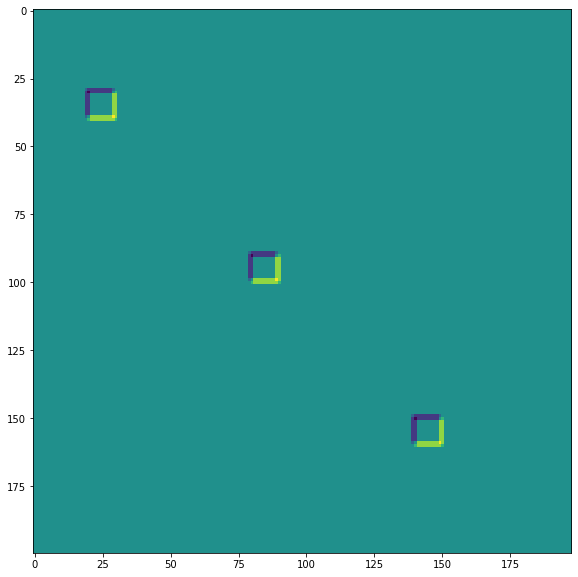

In [156]:
out = lax.conv_general_dilated(img,    # lhs = image tensor
                               kernel, # rhs = conv kernel tensor
                               (1,1),  # window strides
                               'SAME', # padding mode
                               (1,1),  # lhs/image dilation
                               (1,1),  # rhs/kernel dilation
                               dn)     # dimension_numbers = lhs, rhs, out dimension permutation
print("out shape: ", out.shape)
print("First output channel:")
plt.figure(figsize=(10,10))
plt.imshow(onp.array(out)[0,:,:,0]);

#### VALID padding, no stride, no dilation

out shape:  (1, 198, 196, 3) DIFFERENT from above!
First output channel:


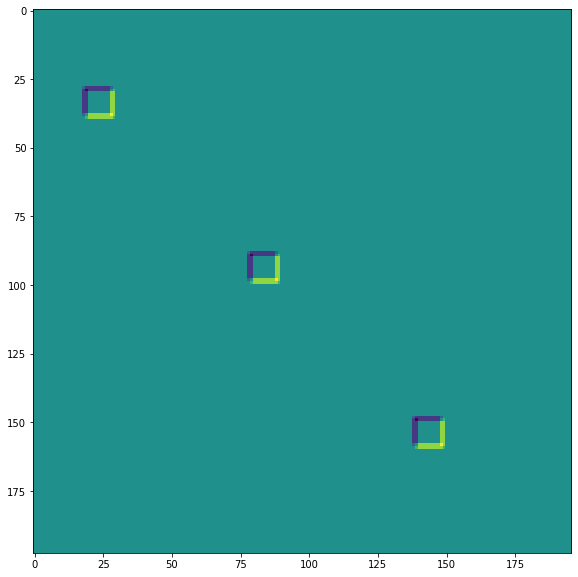

In [157]:
out = lax.conv_general_dilated(img,     # lhs = image tensor
                               kernel,  # rhs = conv kernel tensor
                               (1,1),   # window strides
                               'VALID', # padding mode
                               (1,1),   # lhs/image dilation
                               (1,1),   # rhs/kernel dilation
                               dn)      # dimension_numbers = lhs, rhs, out dimension permutation
print("out shape: ", out.shape, "DIFFERENT from above!")
print("First output channel:")
plt.figure(figsize=(10,10))
plt.imshow(onp.array(out)[0,:,:,0]);

#### SAME padding, 2,2 stride, no dilation

out shape:  (1, 100, 99, 3)  <-- half the size of above
First output channel:


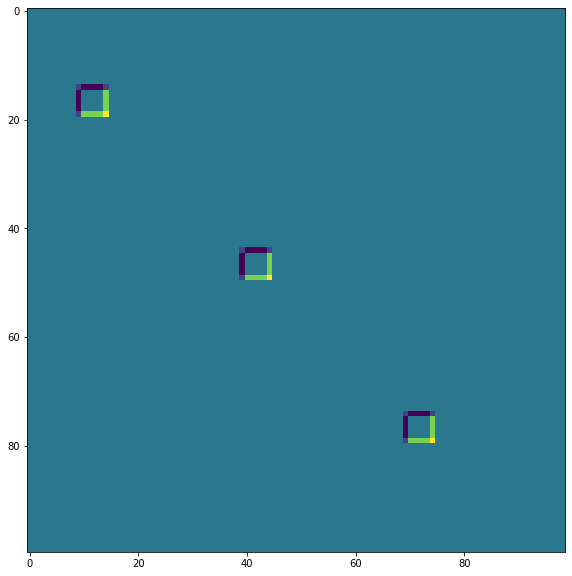

In [158]:
out = lax.conv_general_dilated(img,    # lhs = image tensor
                               kernel, # rhs = conv kernel tensor
                               (2,2),  # window strides
                               'SAME', # padding mode
                               (1,1),  # lhs/image dilation
                               (1,1),  # rhs/kernel dilation
                               dn)     # dimension_numbers = lhs, rhs, out dimension permutation
print("out shape: ", out.shape, " <-- half the size of above")
plt.figure(figsize=(10,10))
print("First output channel:")
plt.imshow(onp.array(out)[0,:,:,0]);

#### VALID padding, no stride, rhs kernel dilation ~ Atrous convolution (excessive to illustrate)

out shape:  (1, 176, 174, 3)
First output channel:


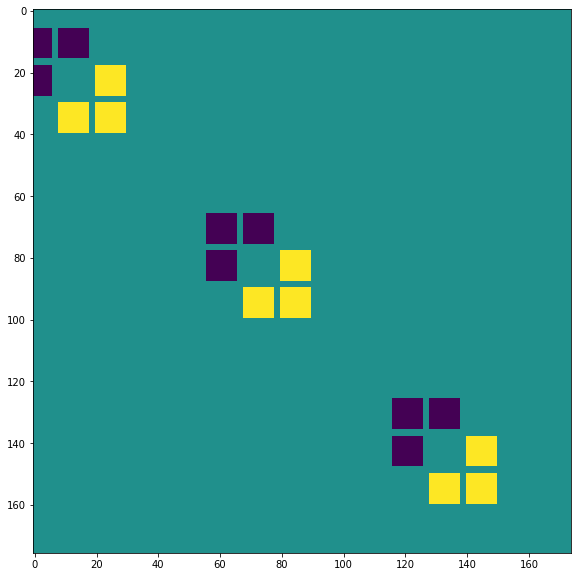

In [159]:
out = lax.conv_general_dilated(img,     # lhs = image tensor
                               kernel,  # rhs = conv kernel tensor
                               (1,1),   # window strides
                               'VALID', # padding mode
                               (1,1),   # lhs/image dilation
                               (12,12), # rhs/kernel dilation
                               dn)      # dimension_numbers = lhs, rhs, out dimension permutation
print("out shape: ", out.shape)
plt.figure(figsize=(10,10))
print("First output channel:")
plt.imshow(onp.array(out)[0,:,:,0]);

#### VALID padding, no stride, lhs=input dilation  ~ Transposed Convolution

out shape:  (1, 397, 393, 3) <-- larger than original!
First output channel:


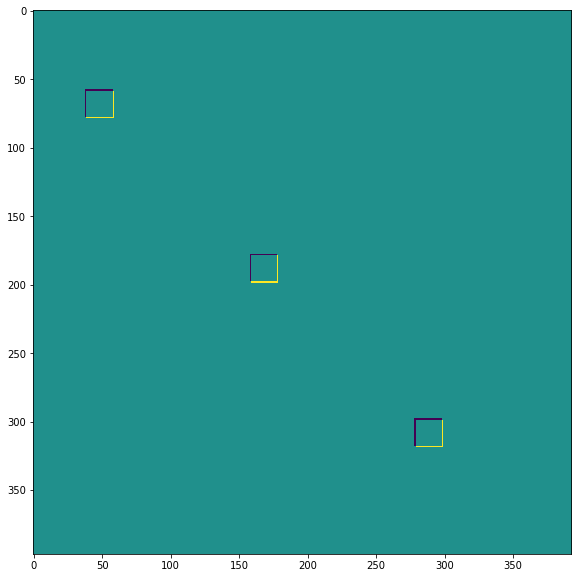

In [160]:
out = lax.conv_general_dilated(img,               # lhs = image tensor
                               kernel,            # rhs = conv kernel tensor
                               (1,1),             # window strides
                               ((0, 0), (0, 0)),  # padding mode
                               (2,2),             # lhs/image dilation
                               (1,1),             # rhs/kernel dilation
                               dn)                # dimension_numbers = lhs, rhs, out dimension permutation
print("out shape: ", out.shape, "<-- larger than original!")
plt.figure(figsize=(10,10))
print("First output channel:")
plt.imshow(onp.array(out)[0,:,:,0]);

We can use the last to, for instance, implement _transposed convolutions_:

out shape:  (1, 400, 396, 3) <-- transposed_conv
First output channel:


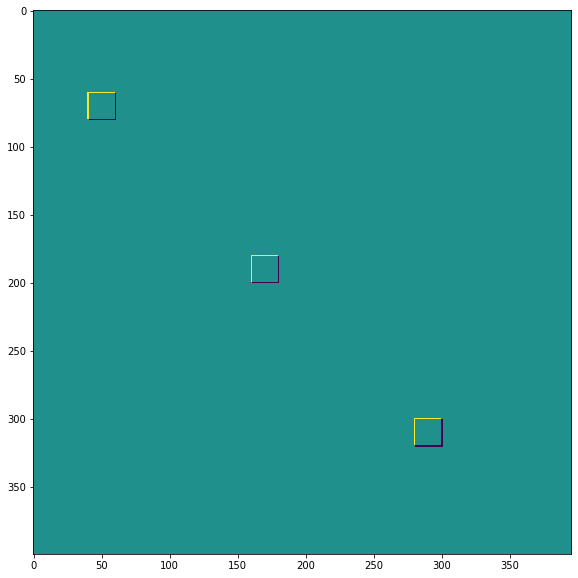

In [161]:
# The following is equivalent to tensorflow:
# N,H,W,C = img.shape
# out = tf.nn.conv2d_transpose(img, kernel, (N,2*H,2*W,C), (1,2,2,1))

# transposed conv = 180deg kernel roation plus LHS dilation
# rotate kernel 180deg:
kernel_rot = np.rot90(np.rot90(kernel, axes=(0,1)), axes=(0,1))
# need a custom output padding:
padding = ((2, 1), (2, 1))
out = lax.conv_general_dilated(img,     # lhs = image tensor
                               kernel_rot,  # rhs = conv kernel tensor
                               (1,1),   # window strides
                               padding, # padding mode
                               (2,2),   # lhs/image dilation
                               (1,1),   # rhs/kernel dilation
                               dn)      # dimension_numbers = lhs, rhs, out dimension permutation
print("out shape: ", out.shape, "<-- transposed_conv")
plt.figure(figsize=(10,10))
print("First output channel:")
plt.imshow(onp.array(out)[0,:,:,0]);

### 1D Convolutions

You aren't limited to 2D convolutions, a simple 1D demo is below:

in shapes: (1, 200, 2) (3, 2, 2)
ConvDimensionNumbers(lhs_spec=(0, 2, 1), rhs_spec=(2, 1, 0), out_spec=(0, 2, 1))
out shape:  (1, 200, 2)


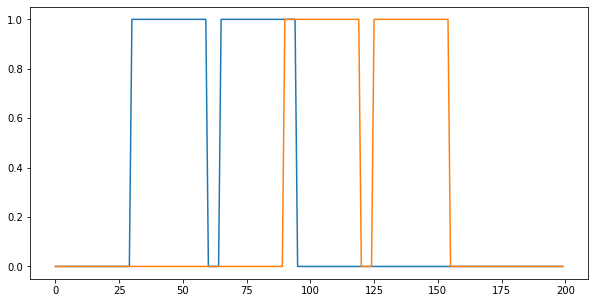

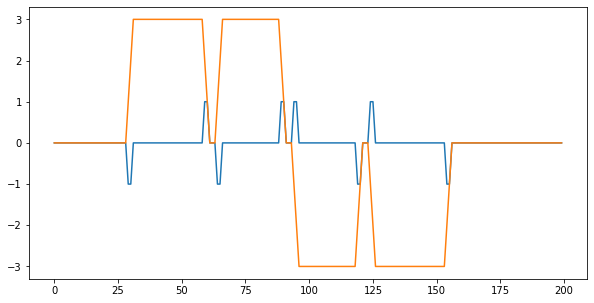

In [162]:
# 1D kernel - WIO layout
kernel = onp.array([[[1, 0, -1], [-1,  0,  1]], 
                    [[1, 1,  1], [-1, -1, -1]]], 
                    dtype=np.float32).transpose([2,1,0])
# 1D data - NWC layout
data = onp.zeros((1, 200, 2), dtype=np.float32)
for i in range(2):
  for k in range(2):
      x = 35*i + 30 + 60*k
      data[0, x:x+30, k] = 1.0

print("in shapes:", data.shape, kernel.shape)

plt.figure(figsize=(10,5))
plt.plot(data[0]);
dn = lax.conv_dimension_numbers(data.shape, kernel.shape,
                                ('NWC', 'WIO', 'NWC'))
print(dn)

out = lax.conv_general_dilated(data,   # lhs = image tensor
                               kernel, # rhs = conv kernel tensor
                               (1,),   # window strides
                               'SAME', # padding mode
                               (1,),   # lhs/image dilation
                               (1,),   # rhs/kernel dilation
                               dn)     # dimension_numbers = lhs, rhs, out dimension permutation
print("out shape: ", out.shape)
plt.figure(figsize=(10,5))
plt.plot(out[0]);

### 3D Convolutions

in shapes: (1, 30, 30, 30, 1) (3, 3, 3, 1, 1)
ConvDimensionNumbers(lhs_spec=(0, 4, 1, 2, 3), rhs_spec=(4, 3, 0, 1, 2), out_spec=(0, 4, 1, 2, 3))
out shape:  (1, 30, 30, 30, 1)


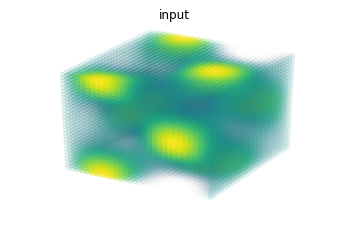

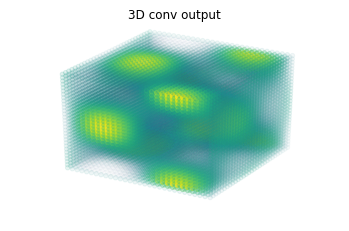

In [163]:
# Random 3D kernel - HWDIO layout
kernel = onp.array([
  [[0, 0,  0], [0,  1,  0], [0,  0,   0]],
  [[0, -1, 0], [-1, 0, -1], [0,  -1,  0]], 
  [[0, 0,  0], [0,  1,  0], [0,  0,   0]]], 
  dtype=np.float32)[:, :, :, onp.newaxis, onp.newaxis]

# 3D data - NHWDC layout
data = onp.zeros((1, 30, 30, 30, 1), dtype=np.float32)
x, y, z = onp.mgrid[0:1:30j, 0:1:30j, 0:1:30j]
data += (onp.sin(2*x*np.pi)*onp.cos(2*y*np.pi)*onp.cos(2*z*np.pi))[None,:,:,:,None]

print("in shapes:", data.shape, kernel.shape)
dn = lax.conv_dimension_numbers(data.shape, kernel.shape,
                                ('NHWDC', 'HWDIO', 'NHWDC'))
print(dn)

out = lax.conv_general_dilated(data,    # lhs = image tensor
                               kernel,  # rhs = conv kernel tensor
                               (1,1,1), # window strides
                               'SAME',  # padding mode
                               (1,1,1), # lhs/image dilation
                               (1,1,1), # rhs/kernel dilation
                               dn)      # dimension_numbers
print("out shape: ", out.shape)

# Make some simple 3d density plots:
from mpl_toolkits.mplot3d import Axes3D
def make_alpha(cmap):
  my_cmap = cmap(np.arange(cmap.N))
  my_cmap[:,-1] = np.linspace(0, 1, cmap.N)**3
  return mpl.colors.ListedColormap(my_cmap)
my_cmap = make_alpha(plt.cm.viridis)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(x.ravel(), y.ravel(), z.ravel(), c=data.ravel(), cmap=my_cmap)
ax.axis('off')
ax.set_title('input')
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(x.ravel(), y.ravel(), z.ravel(), c=out.ravel(), cmap=my_cmap)
ax.axis('off')
ax.set_title('3D conv output');

## 🔪 NaNs

### Debugging NaNs

If you want to trace where NaNs are occurring in your functions or gradients, you can turn on the NaN-checker by:
- setting the `JAX_DEBUG_NANS=True` environment variable.
- adding `from jax.config import config` and `config.update("jax_debug_nans", True)` near the top of your main file
- adding `from jax.config import config` and `config.parse_flags_with_absl()` to your main file, then set the option using a command-line flag like `--jax_debug_nans=True`.

This will cause computations to error-out immediately on production of a NaN.

⚠️ You shouldn't have the NaN-checker on if you're not debugging, as it can introduce lots of device-host round-trips and performance regressions!


## Double (64bit) precision

At the moment, JAX by default enforces single-precision numbers to mitigate the Numpy API's tendency to aggressively promote operands to `double`.  This is the desired behavior for many machine-learning applications, but it may catch you by surprise!

In [164]:
x = random.uniform(random.PRNGKey(0), (1000,), dtype=np.float64)
x.dtype

dtype('float32')

To use double-precision numbers, you need to set the `jax_enable_x64` configuration variable __at startup__.  

There are a few ways to do this:

1. You can enable 64bit mode by setting the environment variable `JAX_ENABLE_X64=True`.

2. You can manually set the `jax_enable_x64` configuration flag at startup:

```
# again, this only works on startup!
from jax.config import config
config.update("jax_enable_x64", True)
```

3. You can parse command-line flags with `absl.app.run(main)`

```
from jax.config import config
config.config_with_absl()
```

4. If you want JAX to run absl parsing for you, i.e. you don't want to do `absl.app.run(main)`, you can instead use

```
from jax.config import config
if __name__ == '__main__':
  # calls config.config_with_absl() *and* runs absl parsing
  config.parse_flags_with_absl()
```

Note that #2-#4 work for _any_ of JAX's configuration options.

We can then confirm that `x64` mode is enabled:

In [165]:
from jax import numpy as np, random
x = random.uniform(random.PRNGKey(0), (1000,), dtype=np.float64)
x.dtype # --> dtype('float64')

dtype('float32')

### Caveats
⚠️ XLA doesn't support 64-bit convolutions on all backends!

## Fin.

If something's not covered here that has caused you weeping and gnashing of teeth, please let us know and we'll extend these introductory _advisos_!